In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pandas as pd
import matplotlib.pylab as plt

plt.rcParams['lines.linewidth'] = 3

In [2]:
def calc_height(t, p, variant = 'ithf'):
    '''
    isotherm height formular
    z = -R*t0/g * ln(p/p0)
    z = -287.053*t0/9.80665 * ln(p/p0)
    
    polytrop height forumular
    z = t0/L * ((p/p0)**(-L*R/g) -1)
    L = −0.0065 K/m
    R = 287.053 J/(kg K)
    g = 9.80665 m/s2
    z = t0/−0.0065 * ((p/p0)**(0.0065*287.053/9.80665) -1)
    
    international height formular
    z = 288.15/0.0065 * (1- (p/1013.25)**(1/5.255))
    
    '''
    z = []
    for i in range(len(t)):
        if i == 0:
            z.append(0)
        else:
            if variant == 'ithf':
                height = -287.053*numpy.mean(t)/9.80665 * numpy.log(p[i]/p[0])
            elif variant == 'pthf':
                if z[-1] >= 11000:
                    height = t[0]/-0.004 * ((p[i]/p[0])**(0.004*287.053/9.80665) -1)
                else:
                    height = t[0]/-0.0065 * ((p[i]/p[0])**(0.0065*287.053/9.80665) -1)
            z.append(height)
    return z

# to gpm
from scipy.integrate import quad

def integrand(x):
    return (6371000 / (6371000 + x))**2
def expint(x):
    return quad(integrand, 0, x,)[0]


In [3]:
def inverse_haversine(lat, lon, distance, direction):
    '''
    distance: [km]
    '''
    lat = numpy.radians(lat)
    lon = numpy.radians(lon)
    d = numpy.array(distance)
    r = 6371 #[km]
    if direction == "NORTH":
        brng = 0.
    elif direction == "EAST":
        brng = 1.5707963267948966
    else:
        return "error - not a valid direction"
    return_lat = numpy.arcsin(numpy.sin(lat) * numpy.cos(d / r) + numpy.cos(lat) * numpy.sin(d / r) * numpy.cos(brng))
    return_lon = lon + numpy.arctan2(numpy.sin(brng) * numpy.sin(d / r) * numpy.cos(lat), numpy.cos(d / r) - numpy.sin(lat) * numpy.sin(return_lat))

    return numpy.degrees(return_lat), numpy.degrees(return_lon)

In [4]:
# from haversine import inverse_haversine, Direction
def transport(lat, lon, u_dist, v_dist):
    '''
    dist: [km]
    '''
    new_lat, new_lon = inverse_haversine(lat, lon, u_dist, "EAST")
    new_lat, new_lon = inverse_haversine(new_lat, new_lon, v_dist, "NORTH")
    return new_lat, new_lon

In [5]:
def trajectory(lat, lon, u, v, pressure, temperature, w_rs = 5.5):
    '''
    w_rs -> radio sonde rising speed
    '''
    z = calc_height(temperature, pressure, 'pthf') # m from K and Pa
#     print(temperature, pressure)
#     vec_expint = numpy.vectorize(expint)
#     z = vec_expint(z)
    
    lat_displacement = [0.]
    lon_displacement = [0.]
    
    for i in range(len(z)):
        if i == 0:
            new_lat = lat
            new_lon = lon
        else:
            rising_time = (z[i]-z[i-1]) / w_rs
#             print(z[i], z[i-1], z[i]-z[i-1], rising_time)
            new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000., (np.mean([v[i],v[i-1]]) * rising_time)/1000.)
#             new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000., (v[i] * rising_time)/1000.)
            lat_displacement.append(lon - new_lon)
            lon_displacement.append(lat - new_lat)
#         lat_displacement.append(new_lat)
#         lon_displacement.append(new_lon)

    return lat_displacement, lon_displacement


---
---
---

In [8]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    while 1:
        try:
            # get handle for message
            bufr = codes_bufr_new_from_file(f)
            if bufr is None:
                break
            # we need to instruct ecCodes to expand all the descriptors
            # i.e. unpack the data section
            if codes_get_array(bufr,'dataSubCategory')[0]!=109:
                codes_release(bufr)
                continue
            codes_set(bufr, 'unpack', 1)
            # get all the timePeriods
            iterid = codes_bufr_keys_iterator_new(bufr)

            # loop over the keys
            #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
                ##print (codes_get_array(bufr,'dataSubCategory')[0])
                #codes_release(bufr)
                #continue
            hires=False
            while codes_bufr_keys_iterator_next(iterid):

                # print key name
                keyname = codes_bufr_keys_iterator_get_name(iterid)
    #             print(keyname,codes_get_array(bufr,keyname))
                #if keyname in ['#1#blockNumber','#1#stationNumber']:
                    #print (keyname,codes_get_array(bufr,keyname))
                if 'latitudeDisplacement' in keyname:
                    hires=True
            if not hires:
                codes_bufr_keys_iterator_delete(iterid)
                continue
            ## delete the key iterator
            codes_bufr_keys_iterator_delete(iterid)
            output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
            output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
            output['pressure'] = codes_get_array(bufr, "pressure")
            output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
            output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
            output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
            output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
            output['airTemperature'] = codes_get_array(bufr, "airTemperature")
            dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
            output['windDirection'] = codes_get_array(bufr, "windDirection")
            output['windSpeed'] = codes_get_array(bufr, "windSpeed")
            output['lat'] = codes_get(bufr, "latitude")
            output['lon'] = codes_get(bufr, "longitude")
            output['alt'] = float(codes_get(bufr, "heightOfStation"))
            output['blockNumber'] = codes_get(bufr, "blockNumber")
            output['stationNumber'] = codes_get(bufr, "stationNumber")
            data = pd.DataFrame.from_dict(output)
            u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
            data['u'] = u
            v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
            data['v'] = v
            data = data[data.airTemperature < 350]
            data = data[data.airTemperature > 180]

            lat_displacement, lon_displacement = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature))

            reduced = data[numpy.isin(data.pressure, [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000])]
            reduced_lat_displacement, reduced_lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))

            print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
            plt.plot(data.pressure,np.array(lat_displacement),color = 'blue', label='calc lat disp')
            plt.plot(data.pressure,np.array(lon_displacement),color = 'red', label='calc lon disp')
            plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
            plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
            plt.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
            plt.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')

            plt.title('height calc')
            plt.legend()
            plt.grid()
            plt.show()
            plt.close()
            bc += 1
        except:
            pass
        if bc > 100:
            break
        
    return output


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>
-40.900000000000006 174.98000000000002 19201130.0 213100.0


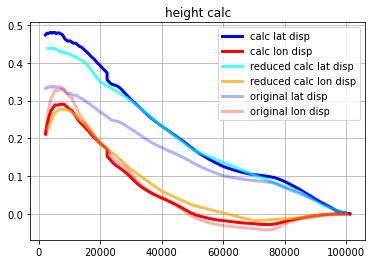

48.24 11.55 19201130.0 224500.0


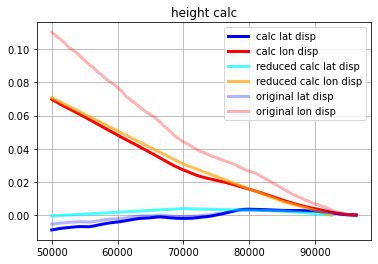

48.830000000000005 9.200000000000001 19201130.0 224500.0


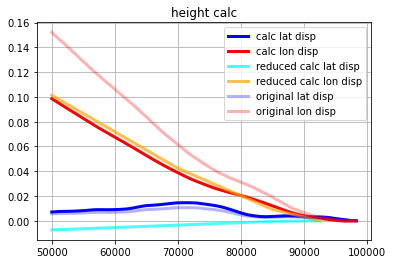

51.410000000000004 6.970000000000001 19201130.0 224500.0


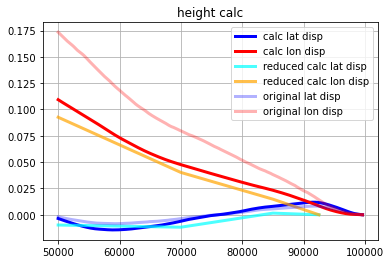

50.56 10.38 19201130.0 224500.0


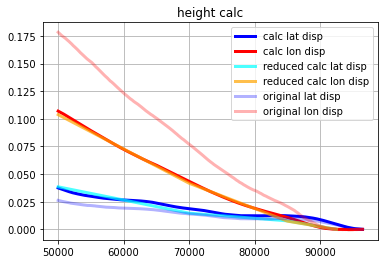

54.1 13.410000000000002 19201130.0 224400.0


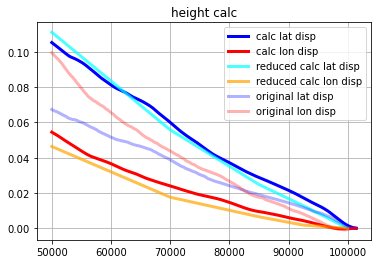

54.53 9.55 19201130.0 224400.0


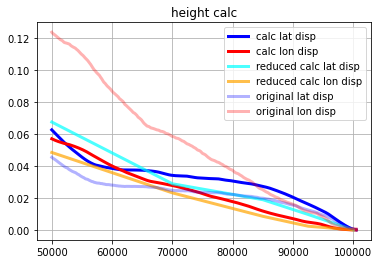

53.71 7.15 19201130.0 224500.0


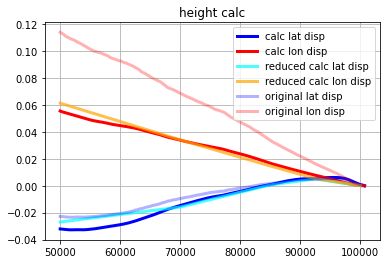

49.43000000000001 11.9 19201130.0 224500.0


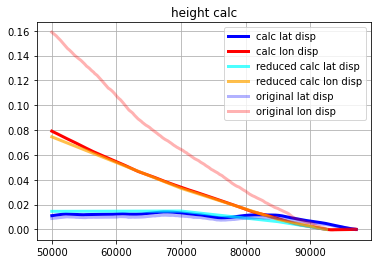

52.82000000000001 9.92 19201130.0 224600.0


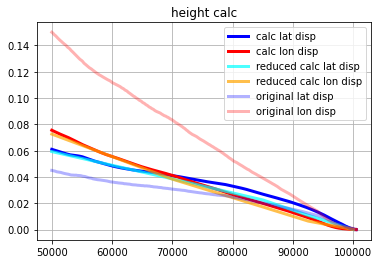

49.690000000000005 7.330000000000001 19201130.0 224700.0


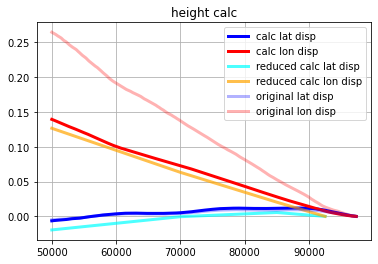

51.410000000000004 6.970000000000001 19201130.0 224500.0


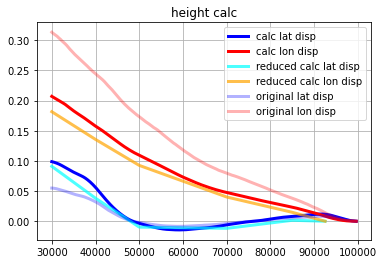

48.830000000000005 9.200000000000001 19201130.0 224500.0


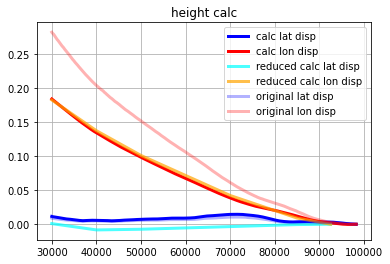

48.24 11.55 19201130.0 224500.0


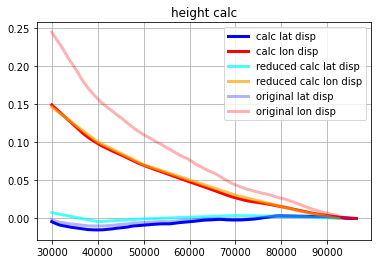

50.56 10.38 19201130.0 224500.0


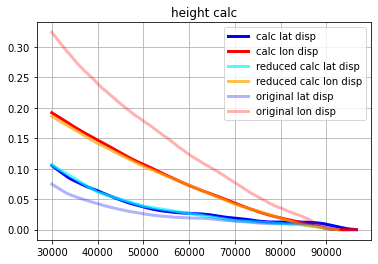

-36.790000000000006 174.62 19201130.0 215600.0


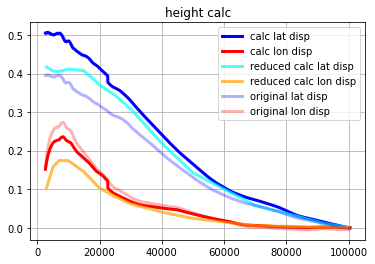

54.1 13.410000000000002 19201130.0 224400.0


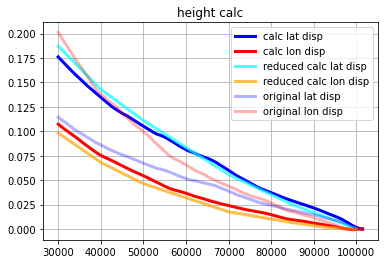

52.82000000000001 9.92 19201130.0 224600.0


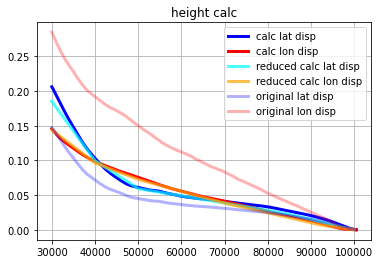

49.690000000000005 7.330000000000001 19201130.0 224700.0


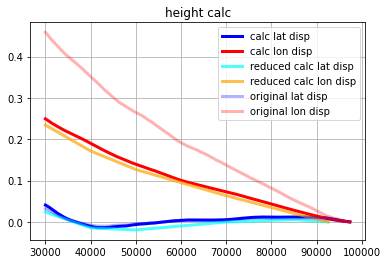

54.53 9.55 19201130.0 224400.0


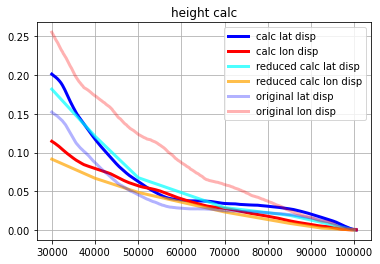

53.71 7.15 19201130.0 224500.0


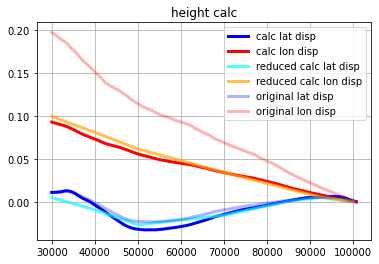

49.43000000000001 11.9 19201130.0 224500.0


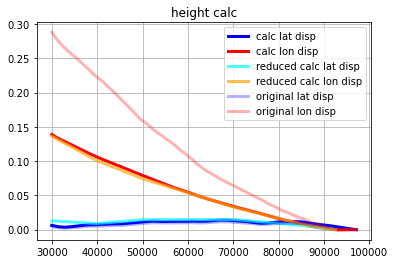

51.410000000000004 6.970000000000001 19201130.0 224500.0


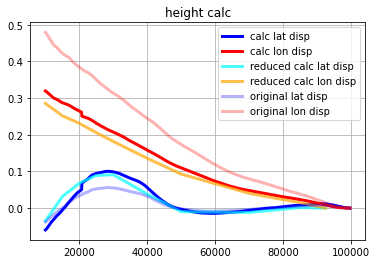

51.410000000000004 6.970000000000001 19201130.0 224500.0


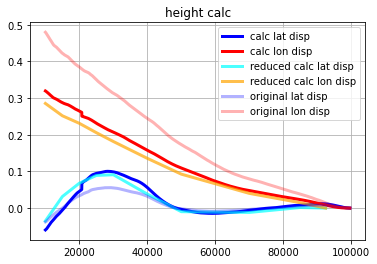

48.830000000000005 9.200000000000001 19201130.0 224500.0


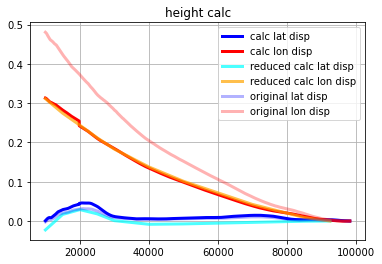

48.830000000000005 9.200000000000001 19201130.0 224500.0


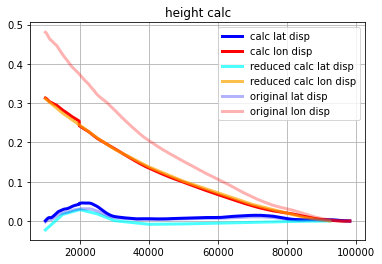

45.46 9.280000000000001 19201130.0 224700.0


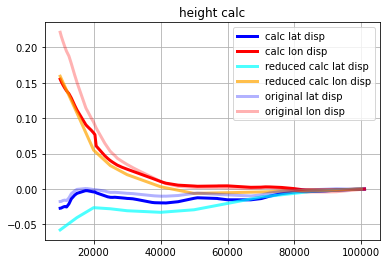

54.1 13.410000000000002 19201130.0 224400.0


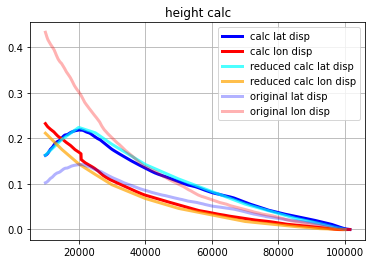

54.1 13.410000000000002 19201130.0 224400.0


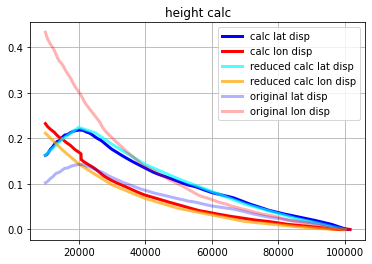

48.24 11.55 19201130.0 224500.0


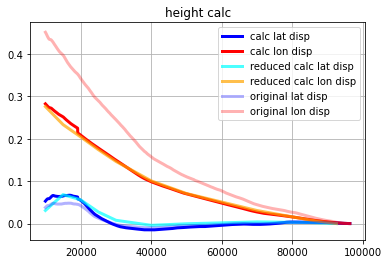

50.56 10.38 19201130.0 224500.0


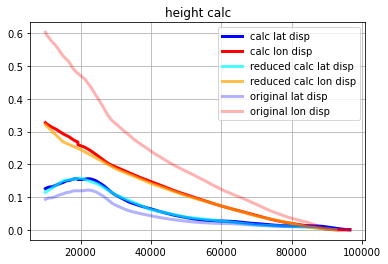

52.82000000000001 9.92 19201130.0 224600.0


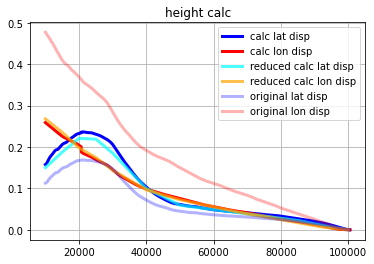

48.24 11.55 19201130.0 224500.0


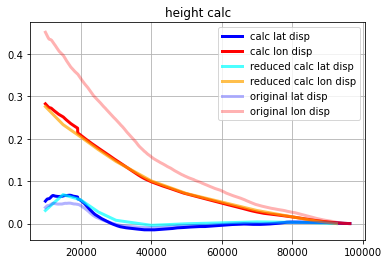

50.56 10.38 19201130.0 224500.0


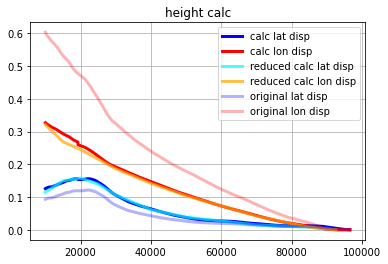

49.690000000000005 7.330000000000001 19201130.0 224700.0


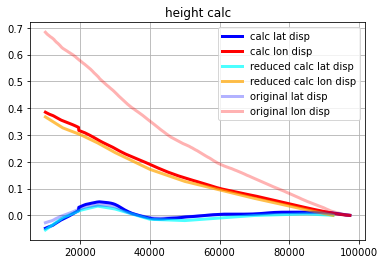

52.82000000000001 9.92 19201130.0 224600.0


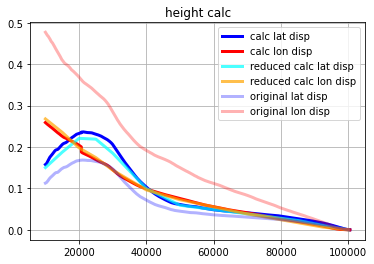

49.690000000000005 7.330000000000001 19201130.0 224700.0


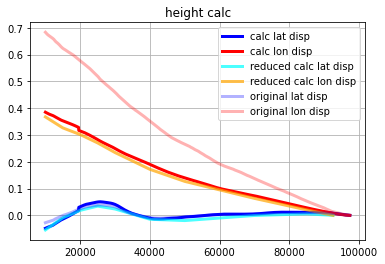

53.71 7.15 19201130.0 224500.0


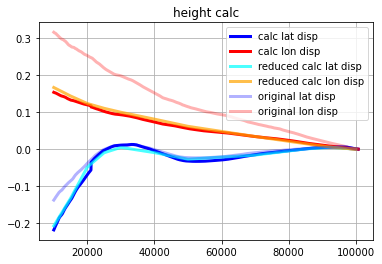

53.71 7.15 19201130.0 224500.0


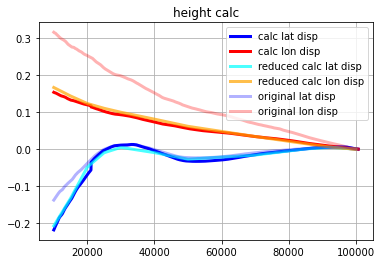

46.81 6.94 19201130.0 230000.0


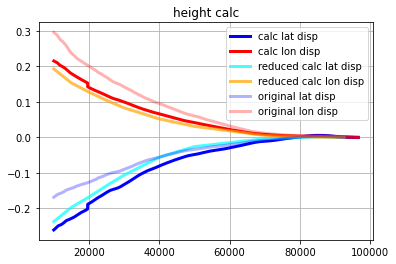

54.53 9.55 19201130.0 224400.0


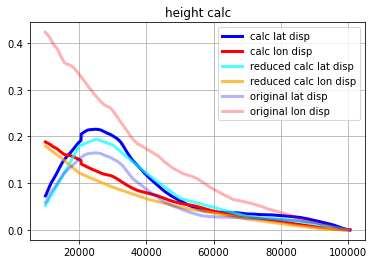

39.35 8.97 19201130.0 225700.0


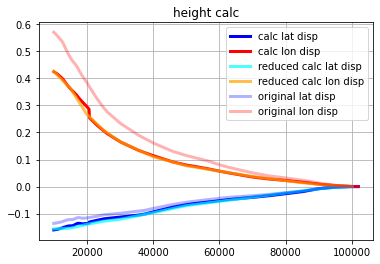

54.53 9.55 19201130.0 224400.0


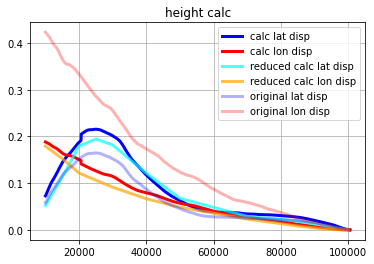

45.980000000000004 13.06 19201130.0 225900.0


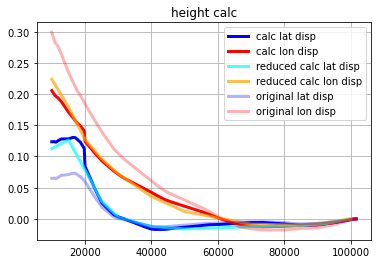

45.980000000000004 13.06 19201130.0 225900.0


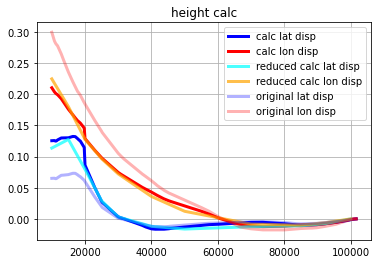

44.77 20.42 19201130.0 231900.0


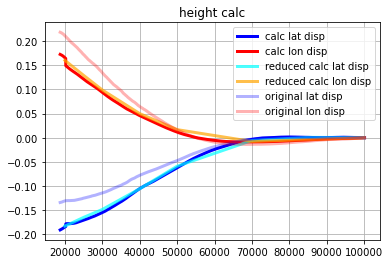

55.2 -162.72000000000003 19201130.0 230100.0


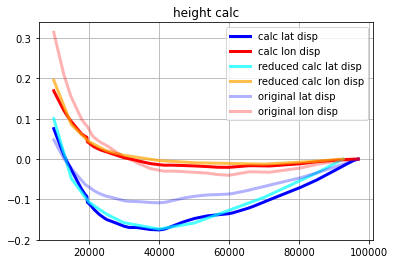

66.89 -162.61 19201130.0 230100.0


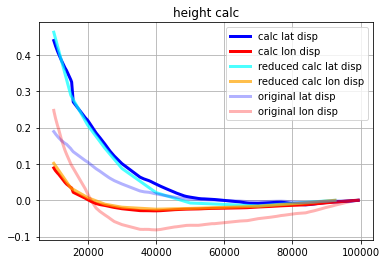

66.89 -162.61 19201130.0 230100.0


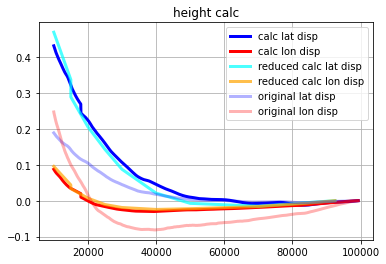

55.2 -162.72000000000003 19201130.0 230100.0


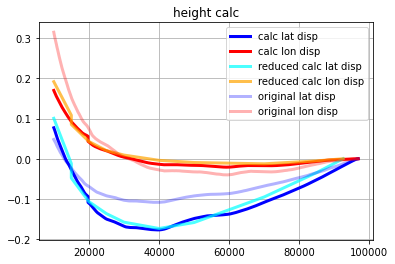

49.43000000000001 11.9 19201130.0 224500.0


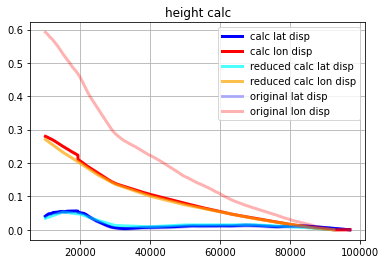

49.43000000000001 11.9 19201130.0 224500.0


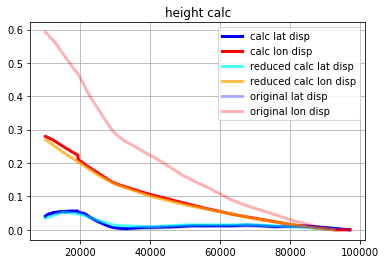

40.660000000000004 17.96 19201130.0 230000.0


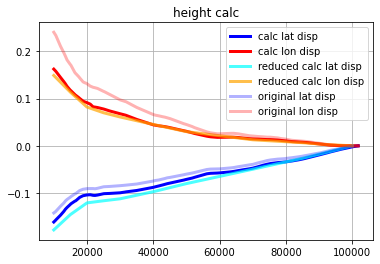

43.06 -108.48 19201130.0 230100.0


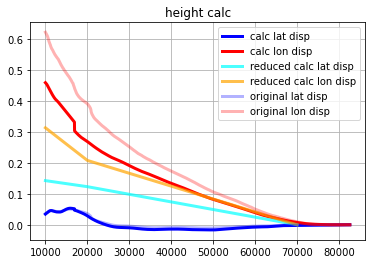

44.1 15.340000000000002 19201130.0 231000.0


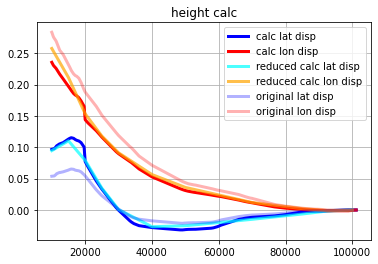

41.67 12.450000000000001 19201130.0 230000.0


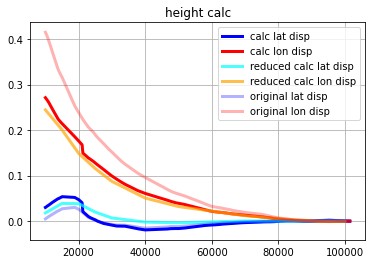

64.51 -165.43 19201130.0 230100.0


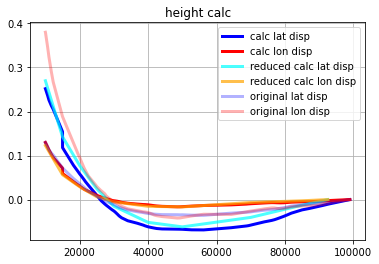

64.51 -165.43 19201130.0 230100.0


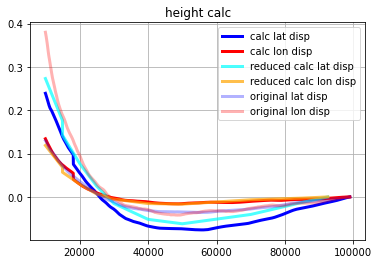

44.650000000000006 11.620000000000001 19201130.0 230000.0


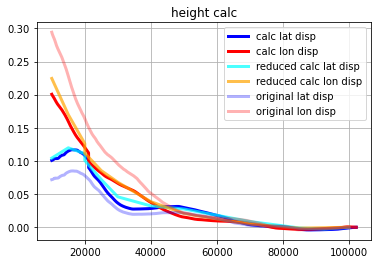

58.68000000000001 -156.67000000000002 19201130.0 230100.0


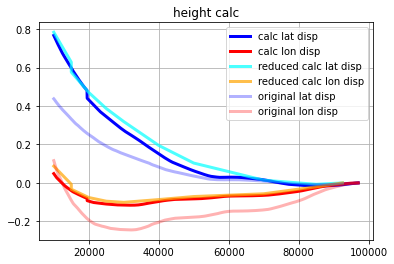

58.68000000000001 -156.67000000000002 19201130.0 230100.0


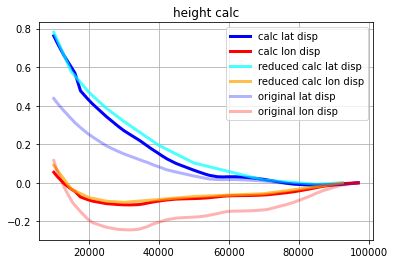

35.040000000000006 -106.62 19201130.0 230300.0


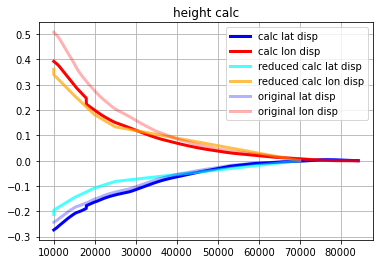

37.760000000000005 -99.97000000000001 19201130.0 230100.0


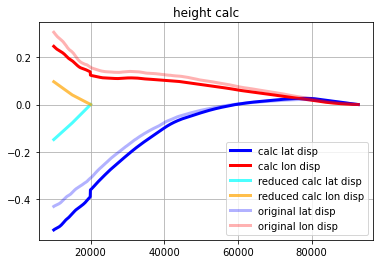

40.86000000000001 -115.74000000000001 19201130.0 230300.0


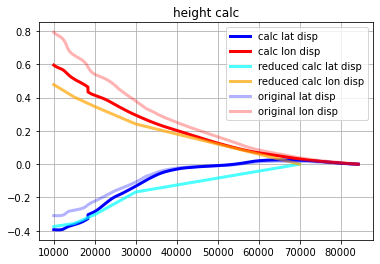

35.17 128.57000000000002 19201130.0 232000.0


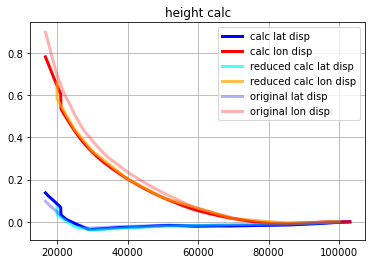

39.120000000000005 -108.53000000000002 19201130.0 230100.0


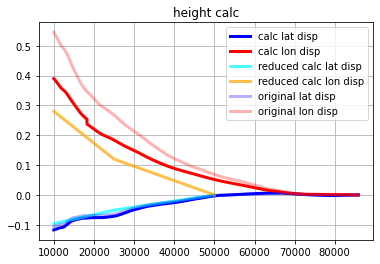

39.42 -83.82000000000001 19201130.0 230500.0


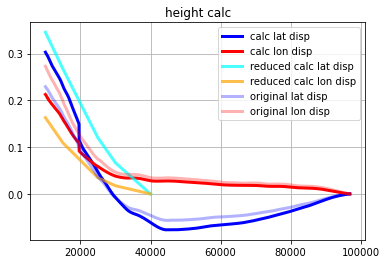

68.71000000000001 -52.85 19201130.0 230700.0


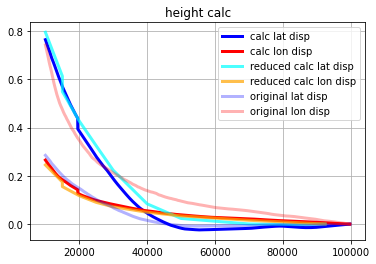

57.74 -152.49 19201130.0 230100.0


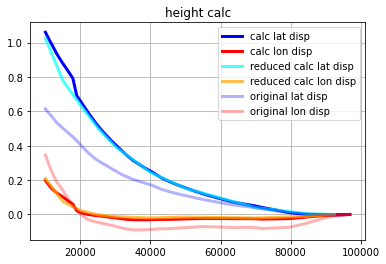

57.74 -152.49 19201130.0 230100.0


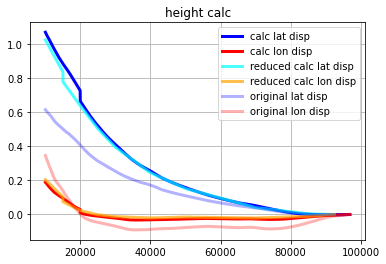

63.970000000000006 -22.590000000000003 19201130.0 230500.0


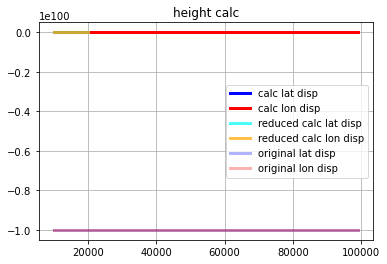

37.910000000000004 12.49 19201130.0 230200.0


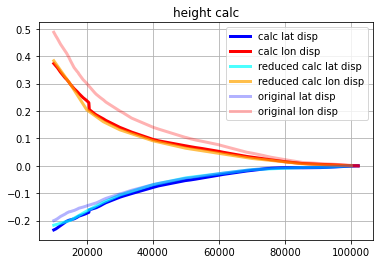

40.150000000000006 -89.34 19201130.0 230100.0


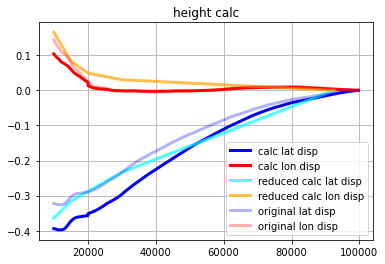

13.48 144.79000000000002 19201130.0 230100.0


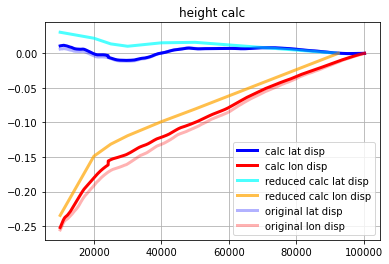

40.53 -80.22000000000001 19201130.0 230800.0


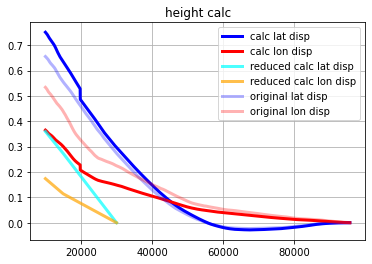

47.43000000000001 19.180000000000003 19201130.0 231900.0


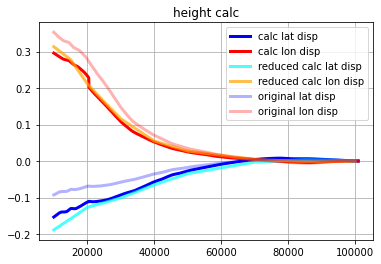

27.71 -82.4 19201130.0 230300.0


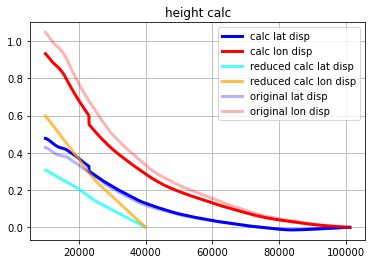

34.84 -92.26 19201130.0 231100.0


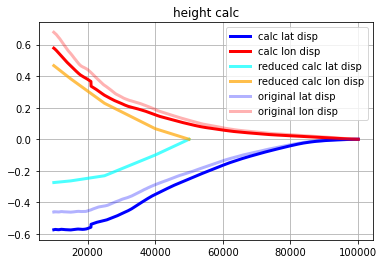

36.25 -86.56 19201130.0 230700.0


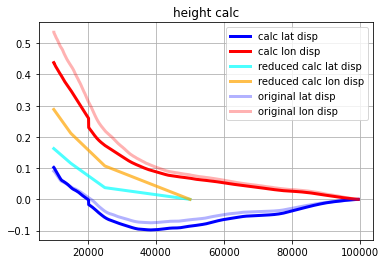

35.230000000000004 -101.71000000000001 19201130.0 230600.0


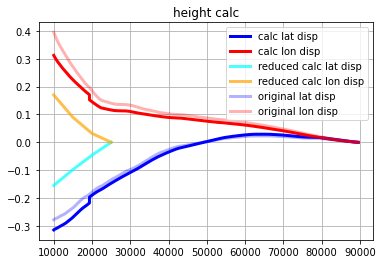

47.68000000000001 -117.63000000000001 19201130.0 230400.0


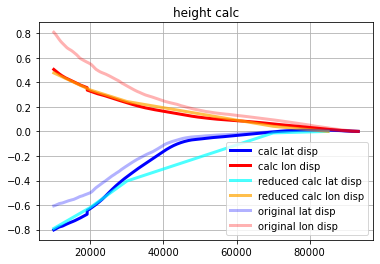

42.940000000000005 -78.72000000000001 19201130.0 231300.0


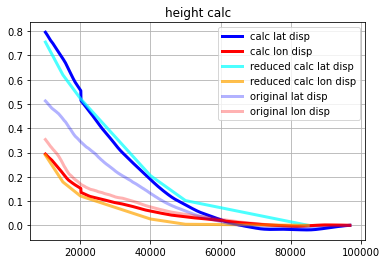

27.78 -97.51 19201130.0 230800.0


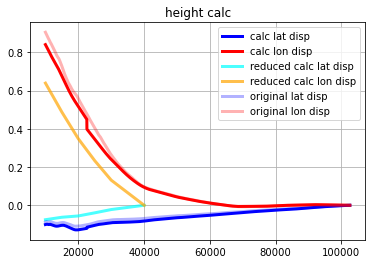

42.38 -122.88000000000001 19201130.0 230400.0


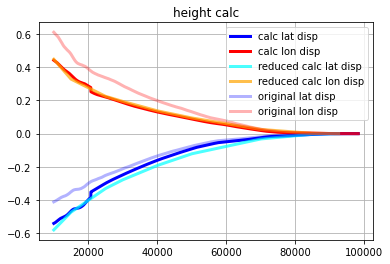

-68.57000000000001 77.97000000000001 19201130.0 231500.0


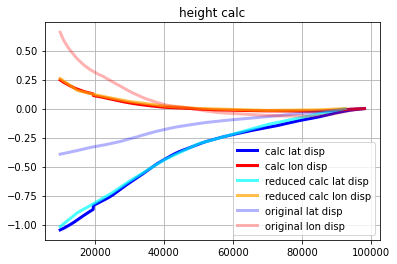

40.220000000000006 44.50000000000001 19201130.0 225900.0


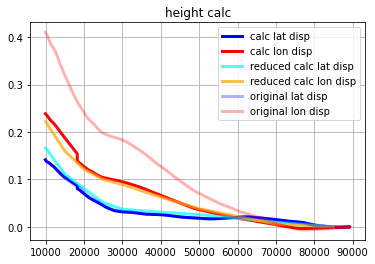

-26.610000000000003 118.54 19201130.0 231500.0


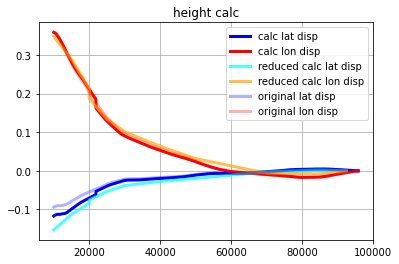

44.910000000000004 -84.72000000000001 19201130.0 230600.0


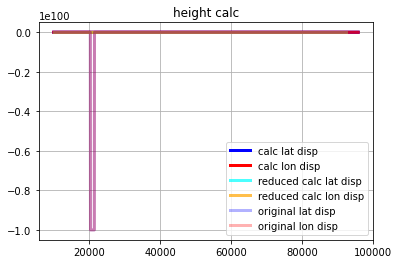

-74.7 164.09 19201130.0 225400.0


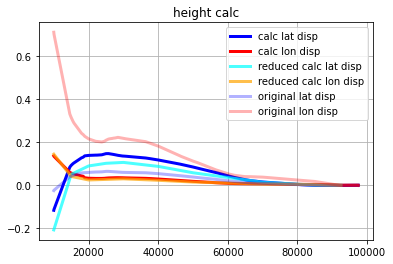

-66.28 110.52000000000001 19201130.0 231500.0


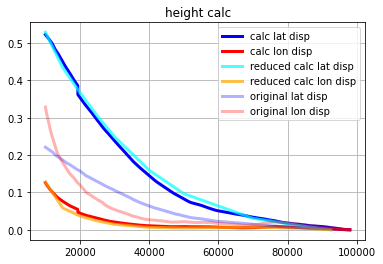

41.92 8.790000000000001 19201130.0 231800.0


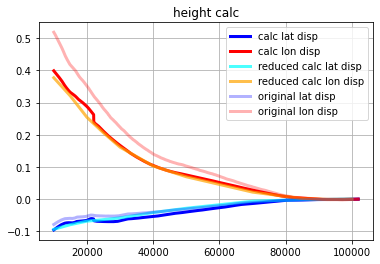

31.94 -102.19000000000001 19201130.0 230300.0


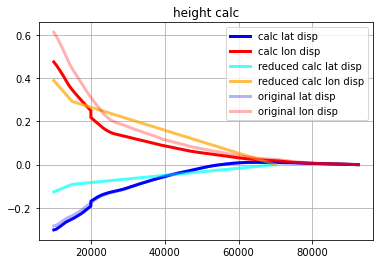

32.32 -90.08000000000001 19201130.0 230600.0


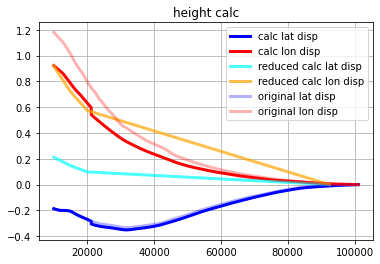

44.85 -93.56 19201130.0 230300.0


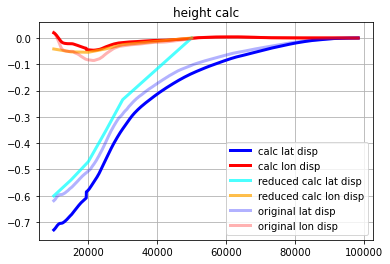

42.690000000000005 -73.83000000000001 19201130.0 230600.0


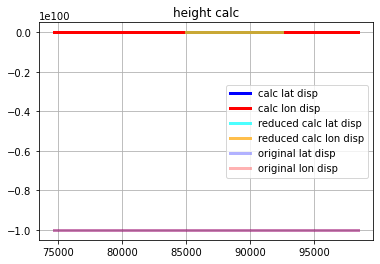

46.260000000000005 20.090000000000003 19201130.0 231400.0


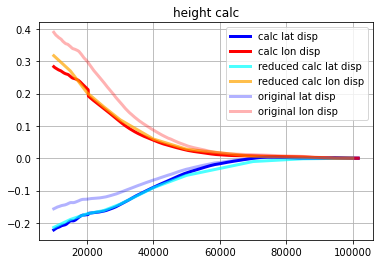

-54.50000000000001 158.94000000000003 19201130.0 230000.0


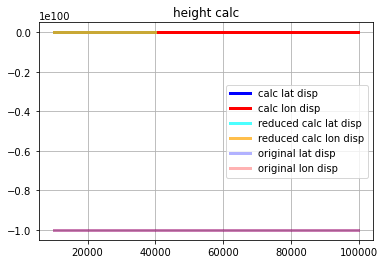

-54.50000000000001 158.94000000000003 19201130.0 230000.0


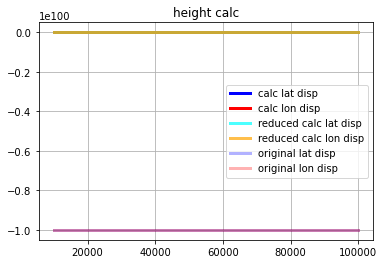

-29.040000000000003 167.94000000000003 19201130.0 230000.0


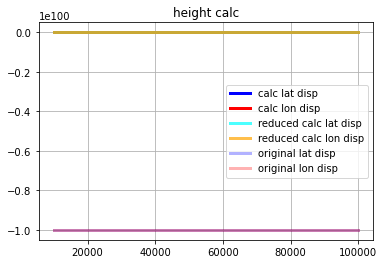

-29.040000000000003 167.94000000000003 19201130.0 230000.0


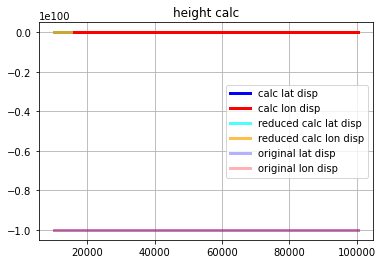

40.53 22.970000000000002 19201130.0 231200.0


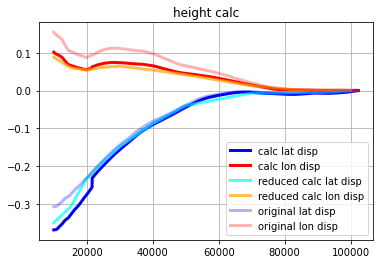

In [9]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()


In [6]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    while 1:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        return output


In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()


In [22]:
data = pd.DataFrame.from_dict(out)
u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
data['u'] = u
v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
data['v'] = v
data = data[data.airTemperature < 350]
data = data[data.airTemperature > 180]
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
data


,datum,timePeriod,pressure,extendedVerticalSoundingSignificance,geopotentialHeight,latitudeDisplacement,longitudeDisplacement,airTemperature,windDirection,windSpeed,lat,lon,alt,blockNumber,stationNumber,u,v
0,19201130.0,213100.0,101130.0,145408,7,0.00000,0.00000,285.85,178,8.7,-40.9,174.98,8.0,93,417,-8.694700,0.303626
1,19201130.0,213100.0,101050.0,0,14,0.00025,-0.00017,285.64,175,7.3,-40.9,174.98,8.0,93,417,-7.272221,0.636237
2,19201130.0,213100.0,101040.0,0,15,0.00036,-0.00025,285.52,173,6.8,-40.9,174.98,8.0,93,417,-6.749314,0.828712
3,19201130.0,213100.0,101010.0,0,17,0.00043,-0.00030,285.52,172,6.6,-40.9,174.98,8.0,93,417,-6.535769,0.918542
4,19201130.0,213100.0,100940.0,0,23,0.00048,-0.00033,285.46,172,6.6,-40.9,174.98,8.0,93,417,-6.535769,0.918542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,19201130.0,213100.0,2230.0,0,25991,0.33203,0.21890,219.65,84,12.5,-40.9,174.98,8.0,93,417,1.306606,12.431524
3640,19201130.0,213100.0,2220.0,0,26019,0.33202,0.21821,219.77,85,12.6,-40.9,174.98,8.0,93,417,1.098162,12.552053
3641,19201130.0,213100.0,2210.0,0,26048,0.33200,0.21750,219.99,86,12.7,-40.9,174.98,8.0,93,417,0.885907,12.669063
3642,19201130.0,213100.0,2200.0,0,26080,0.33198,0.21656,220.31,87,12.8,-40.9,174.98,8.0,93,417,0.669900,12.782458


---
---

In [74]:
0.0065*0.9

0.00585

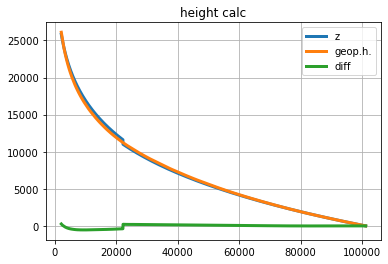

In [75]:
z = calc_height(data.airTemperature, data.pressure, 'pthf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

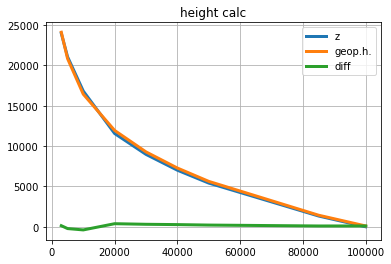

In [76]:
z = calc_height(np.array(reduced.airTemperature), np.array(reduced.pressure), 'pthf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(reduced.pressure,z,label='z')
plt.plot(reduced.pressure,reduced.geopotentialHeight,label='geop.h.')
plt.plot(reduced.pressure,reduced.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

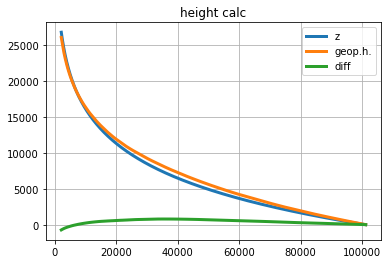

In [78]:
z = calc_height(data.airTemperature, data.pressure, 'ithf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

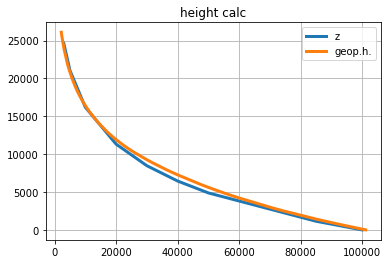

In [77]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
z = calc_height(np.array(reduced.airTemperature), np.array(reduced.pressure))
vec_expint = numpy.vectorize(expint)
z = vec_expint(z)

plt.plot(reduced.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

---
---

In [16]:
lat = data.lat.iloc[0]
lon = data.lon.iloc[0]
print(lat, lon)
print(transport(lat, lon, [111,-111],[0,0]))

print(transport(lat, lon, 100,0))
print(transport(lat, lon, -100,0))

print(transport(lat, lon, 0,100))
print(transport(lat, lon, 0,-100))

-40.900000000000006 174.98000000000002
(array([-40.89246784, -40.89246784]), array([176.30058825, 173.65941175]))
(-40.89388663614691, 176.16973615202468)
(-40.89388663614691, 173.79026384797538)
(-40.00067839408128, 174.98000000000002)
(-41.79932160591875, 174.98000000000002)


---
---

In [64]:
lat_displacement, lon_displacement = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature))

[285.85 285.64 285.52 ... 219.99 220.31 220.61] [101130. 101050. 101040. ...   2210.   2200.   2190.]


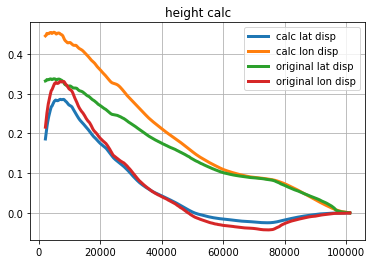

In [65]:
plt.plot(data.pressure,np.array(lat_displacement),label='calc lat disp')
plt.plot(data.pressure,np.array(lon_displacement),label='calc lon disp')
plt.plot(data.pressure,data.latitudeDisplacement,label='original lat disp')
plt.plot(data.pressure,data.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [66]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
lat_displacement, lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))

[284.67 274.17 259.41 245.79 228.56 223.15 217.35 217.16 218.42] [100000.  85000.  50000.  40000.  30000.  20000.  10000.   5000.   3000.]


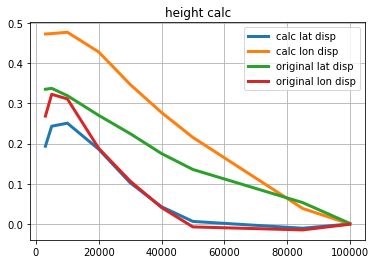

In [67]:
plt.plot(reduced.pressure,lat_displacement,label='calc lat disp')
plt.plot(reduced.pressure,lon_displacement,label='calc lon disp')
plt.plot(reduced.pressure,reduced.latitudeDisplacement,label='original lat disp')
plt.plot(reduced.pressure,reduced.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()